<a href="https://colab.research.google.com/github/allancostajardim/allancostajardim/blob/main/NBA_WebScraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Web Scraping - Dados NBA**
A ideia é fazer uma comparação de desempenho em pontos dos jogadores da NBA nos últimos 10 jogos. Para tal, será necessário buscar os dados na internet, separar os dados relativos aos pontos e calcular média e desvio padrão em cada um. 
Conforme a definição de Desvio Padrão, quanto menor o desvio, maior a regularidade do jogador em torno da média.

In [49]:
from urllib.request import urlopen #biblioteca que faz as requisições à página 
from bs4 import BeautifulSoup #faz leitura e organização dos dados coletados 
import pandas as pd #tratamento dos dados
import re
import requests 
import numpy as np #criação das métricas
from time import sleep

In [93]:
# URL da página contendo dados (nomes e links) dos jogadores da NBA
url = 'https://www.basketball-reference.com/leagues/NBA_2023_per_game.html'

# Faça a requisição GET para a página
response = requests.get(url)

# Crie um objeto BeautifulSoup com o conteúdo da página
soup = BeautifulSoup(response.content, "html.parser")

# Encontre todos os elementos que contêm os nomes dos jogadores e seus links
player_tags = soup.find_all('a', href=True, text=True)

# Crie um dicionário vazio para armazenar os links e nomes dos jogadores
players_dict = {}

# Itere sobre todos os elementos que contêm os nomes dos jogadores e seus links
for player_tag in player_tags:
    # Obtenha o link do jogador
    player_link = player_tag.get('href')
    # Obtenha o nome do jogador
    player_name = player_tag.text
    # Verifique se o link do jogador contém a palavra "players"
    if 'players' in player_link:
        # Adicione o link e o nome do jogador ao dicionário
        players_dict[player_name] = player_link.replace('.html','/')

# Imprima o dicionário de jogadores
players_dict.pop('Player Contracts')
players_dict.pop('Players')
players_dict.pop('...')
print(players_dict)
top_scorers = ['Luka Dončić','Domantas Sabonis','James Harden','Nikola Jokić','Giannis Antetokounmpo','LaMelo Ball','Paolo Banchero',
               'Bradley Beal','Bogdan Bogdanović','Devin Booker','Mikal Bridges','Jaylen Brown','Jalen Brunson','Anthony Davis',
               'Spencer Dinwiddie','Kevin Durant','Joel Embiid','Michael Porter Jr.',"De'Aaron Fox",'Paul George','Shai Gilgeous-Alexander',
               'Jalen Green','Tyrese Haliburton','Tobias Harris','Buddy Hield','Kyrie Irving','LeBron James','Nikola Jović',
               'Kyle Kuzma','Zach LaVine','Kawhi Leonard','Damian Lillard','Kyle Lowry','Lauri Markkanen','Tyrese Maxey',
               'CJ McCollum','Donovan Mitchell','Ja Morant','Jamal Murray','Chris Paul','Jordan Poole',
               'Kristaps Porziņģis','Julius Randle','Terry Rozier',"D'Angelo Russell",'Pascal Siakam','Jayson Tatum','Klay Thompson',
               'Fred VanVleet','Nikola Vučević','Derrick White','Andrew Wiggins','Trae Young']

{'Luka Dončić': '/players/d/doncilu01/', 'Domantas Sabonis': '/players/s/sabondo01/', 'James Harden': '/players/h/hardeja01/', 'Nikola Jokić': '/players/j/jokicni01/', 'Precious Achiuwa': '/players/a/achiupr01/', 'Steven Adams': '/players/a/adamsst01/', 'Bam Adebayo': '/players/a/adebaba01/', 'Ochai Agbaji': '/players/a/agbajoc01/', 'Santi Aldama': '/players/a/aldamsa01/', 'Nickeil Alexander-Walker': '/players/a/alexani01/', 'Grayson Allen': '/players/a/allengr01/', 'Jarrett Allen': '/players/a/allenja01/', 'Jose Alvarado': '/players/a/alvarjo01/', 'Kyle Anderson': '/players/a/anderky01/', 'Giannis Antetokounmpo': '/players/a/antetgi01/', 'Thanasis Antetokounmpo': '/players/a/antetth01/', 'Cole Anthony': '/players/a/anthoco01/', 'OG Anunoby': '/players/a/anunoog01/', 'Ryan Arcidiacono': '/players/a/arcidry01/', 'Deni Avdija': '/players/a/avdijde01/', 'Deandre Ayton': '/players/a/aytonde01/', 'Udoka Azubuike': '/players/a/azubuud01/', 'Marvin Bagley III': '/players/b/baglema01/', 'Patri

In [94]:
#Armazenando URLs em uma lista
url_players={}
for player in top_scorers:
  player_lnk = players_dict[player]
  url_std = "https://www.basketball-reference.com{}gamelog/2023"
  url_teste=url_std.format(player_lnk)
  #url_players.append(url_teste)
  url_players[player]=url_teste

print(url_players)

{'Luka Dončić': 'https://www.basketball-reference.com/players/d/doncilu01/gamelog/2023', 'Domantas Sabonis': 'https://www.basketball-reference.com/players/s/sabondo01/gamelog/2023', 'James Harden': 'https://www.basketball-reference.com/players/h/hardeja01/gamelog/2023', 'Nikola Jokić': 'https://www.basketball-reference.com/players/j/jokicni01/gamelog/2023', 'Giannis Antetokounmpo': 'https://www.basketball-reference.com/players/a/antetgi01/gamelog/2023', 'LaMelo Ball': 'https://www.basketball-reference.com/players/b/ballla01/gamelog/2023', 'Paolo Banchero': 'https://www.basketball-reference.com/players/b/banchpa01/gamelog/2023', 'Bradley Beal': 'https://www.basketball-reference.com/players/b/bealbr01/gamelog/2023', 'Bogdan Bogdanović': 'https://www.basketball-reference.com/players/b/bogdabo01/gamelog/2023', 'Devin Booker': 'https://www.basketball-reference.com/players/b/bookede01/gamelog/2023', 'Mikal Bridges': 'https://www.basketball-reference.com/players/b/bridgmi01/gamelog/2023', 'Ja

In [101]:
results = pd.DataFrame(columns = ['Nome', 'Média', 'Desv. Pad.'])
for player in top_scorers:
  #player = top_scorers[2]
  html = urlopen(url_players[player])
  soup_players = BeautifulSoup(html)
  content = soup_players.find(id="pgl_basic")
##################################################
  headers = [th.getText() for th in content.findAll('tr', limit=2)[0].findAll('th')]
  headers = headers[1:]
##################################################
  rows = content.findAll('tr')[1:]
  player_stats = [[td.getText() for td in rows[i].findAll('td')]
              for i in range(len(rows))]
##################################################
  stats = pd.DataFrame(player_stats, columns = headers)
  dataframe = stats.sort_values(by='Date', ascending=False)
#print(f'Desempenho dos últimos jogos do jogador {player}')
  dataframe = dataframe[['G','Date','Tm', 'Opp', 'MP','FG%','3P','3P%','FT','FTA','FT%','ORB','DRB','TRB','AST','STL','BLK','TOV','PF','PTS','+/-']].dropna(thresh=10)
#dataframe

#dataframe.to_csv("players_csv/{}.csv'.format(player))
###################################################
  dataframe['PTS'] = dataframe['PTS'].astype(int)
  pontos = dataframe['PTS'].tolist()
#print(pontos)
  media = np.average(pontos[:10]).round(2)
  desvpad = np.std(pontos[:10]).round(2)
  print(f'Média de Pontos do jogador {player} é {media} com desvio padrão {desvpad}!')
  sleep(2) 
  results = results.append({'Nome':player,'Média':media,'Desv. Pad.': desvpad},ignore_index = True)


Média de Pontos do jogador Luka Dončić é 31.5 com desvio padrão 12.7!
Média de Pontos do jogador Domantas Sabonis é 20.4 com desvio padrão 5.82!
Média de Pontos do jogador James Harden é 21.0 com desvio padrão 5.53!
Média de Pontos do jogador Nikola Jokić é 23.1 com desvio padrão 5.36!
Média de Pontos do jogador Giannis Antetokounmpo é 34.9 com desvio padrão 13.58!
Média de Pontos do jogador LaMelo Ball é 23.7 com desvio padrão 5.4!
Média de Pontos do jogador Paolo Banchero é 16.2 com desvio padrão 5.98!
Média de Pontos do jogador Bradley Beal é 24.6 com desvio padrão 7.5!
Média de Pontos do jogador Bogdan Bogdanović é 12.6 com desvio padrão 5.9!
Média de Pontos do jogador Devin Booker é 20.7 com desvio padrão 14.39!
Média de Pontos do jogador Mikal Bridges é 23.8 com desvio padrão 9.12!
Média de Pontos do jogador Jaylen Brown é 24.5 com desvio padrão 9.87!
Média de Pontos do jogador Jalen Brunson é 31.5 com desvio padrão 6.62!
Média de Pontos do jogador Anthony Davis é 22.5 com desvio

,Nome,Média,Desv. Pad.
0,Luka Dončić,31.5,12.70
1,Domantas Sabonis,20.4,5.82
2,James Harden,21.0,5.53
3,Nikola Jokić,23.1,5.36
4,Giannis Antetokounmpo,34.9,13.58
5,LaMelo Ball,23.7,5.40
6,Paolo Banchero,16.2,5.98
7,Bradley Beal,24.6,7.50
8,Bogdan Bogdanović,12.6,5.90
9,Devin Booker,20.7,14.39


                  Nome  Média  Desv. Pad.
33     Lauri Markkanen   25.2        3.37
35         CJ McCollum   21.1        3.53
37           Ja Morant   27.7        4.00
42       Julius Randle   24.3        4.10
23       Tobias Harris   11.2        4.53
49      Nikola Vučević   19.6        4.57
17  Michael Porter Jr.   19.0        5.23
31      Damian Lillard   36.1        5.24
43        Terry Rozier   23.6        5.33
3         Nikola Jokić   23.1        5.36
5          LaMelo Ball   23.7        5.40
2         James Harden   21.0        5.53
1     Domantas Sabonis   20.4        5.82


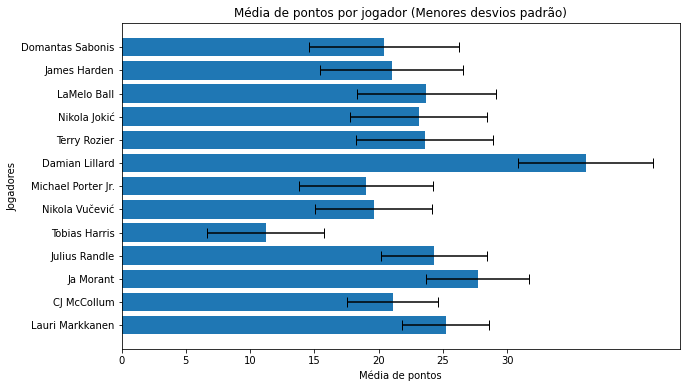

In [108]:
import matplotlib.pyplot as plt

# criar um DataFrame com médias e desvios padrão

results  = results.query('Média >= 10')
results = results.sort_values(by='Desv. Pad.', ascending=True).head(15)
print(results)
# criar o gráfico de barras com barras de erro
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(results['Nome'], results['Média'], xerr=results['Desv. Pad.'], capsize=5)

# adicionar rótulos e título do gráfico
ax.set_xlabel('Média de pontos')
ax.set_ylabel('Jogadores')
ax.set_title('Média de pontos por jogador (Menores desvios padrão)')

# ajustar os rótulos do eixo x
ax.set_xticks(range(0, 31, 5))
# exibir o gráfico
plt.show()